In [1]:
# Import dependencies
import findspark
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from ann_visualizer.visualize import ann_viz
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Initialize findspark
findspark.init()

# Initialize the spark session
spark = SparkSession.builder.appName("SK_categorical_nn").getOrCreate()

In [3]:
# Load in the pre-processed data
s_df = spark.read.csv("../Resources/filtered_encoded_dataset.csv", sep=",", header=True, inferSchema=True)
s_df.show()

+-----------------+--------------------+----------+--------+------------+------+--------+----+-----------+------------+----------------+--------+-------+-------+------------------+----------------+----------------+----------------+----------------+----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|   primary_artist|          track_name|popularity|explicit|danceability|energy|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|      duration_min|time_signature_0|time_signature_1|time_signature_3|time_signature_4|time_signature_5|key_0|key_1|key_2|key_3|key_4|key_5|key_6|key_7|key_8|key_9|key_10|key_11|num_artists_binned_1|num_artists_binned_2|num_artists_binned_3|num_artists_binned_4|num_artists_b

In [4]:
# Remove primary_artist and track_name from the dataset
s_df = s_df.drop("primary_artist", "track_name")
s_df.show()

+----------+--------+------------+------+--------+----+-----------+------------+----------------+--------+-------+-------+------------------+----------------+----------------+----------------+----------------+----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|popularity|explicit|danceability|energy|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|      duration_min|time_signature_0|time_signature_1|time_signature_3|time_signature_4|time_signature_5|key_0|key_1|key_2|key_3|key_4|key_5|key_6|key_7|key_8|key_9|key_10|key_11|num_artists_binned_1|num_artists_binned_2|num_artists_binned_3|num_artists_binned_4|num_artists_binned_5|num_artists_binned_6|track_genre_0|track_genre_1|track_genre_2|track_g

(array([22457.,  9279., 18354., 14910., 19205., 14532.,  9344.,  4269.,
         1101.,    98.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <BarContainer object of 10 artists>)

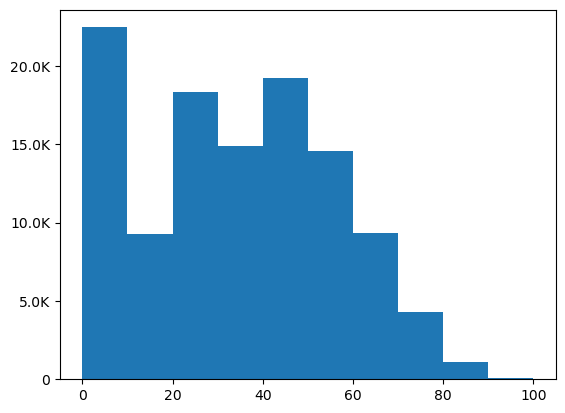

In [5]:
# Check popularity values
fig, ax = plt.subplots()
hist(ax, s_df.select("popularity"))

In [6]:
# Convert the data to a pandas Dataframe
df = s_df.toPandas()
df.head()

,popularity,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,num_artists_binned_4,num_artists_binned_5,num_artists_binned_6,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,track_genre_5,track_genre_6
0,73,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,...,0,0,0,0,0,0,0,0,0,1
1,55,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,...,0,0,0,0,0,0,0,0,0,1
2,57,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,...,0,0,0,0,0,0,0,0,0,1
3,71,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,...,0,0,0,0,0,0,0,0,0,1
4,82,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# Show value counts of popularity to help determine proper bins
df['popularity'].value_counts().sort_index()

popularity
0      15843
1       2116
2       1025
3        570
4        377
       ...  
96         7
97         8
98         7
99         1
100        2
Name: count, Length: 101, dtype: int64

In [8]:
## Bin the popularity into: 0, low=1 (0<pop<=30), medium=2 (30<pop<=60), high=3 (60<pop)
# Set up a list of bins
pop_4bins = [0 ,1, 2, 3]
# Set up list of conditions
pop_4conditions = [
    (df["popularity"] == 0), 
    (df["popularity"] > 0) & (df["popularity"] <= 30),
    (df["popularity"] > 30) & (df["popularity"] <= 60),
    (df["popularity"] > 60)
]
# Set up the column with bins
df["popularity_4bins"] = np.select(pop_4conditions, pop_4bins)

# Set up a list of 3 bins: low=0 (pop<=30), medium=1 (30<pop<=60), high=2 (60<pop)
pop_3bins = [0, 1, 2]
# Set up a list of conditions
pop_3conditions = [
    (df["popularity"] <= 30),
    (df["popularity"] > 30) & (df["popularity"] <= 60),
    (df["popularity"] > 60)
]
# Set up the column with bins
df["popularity_3bins"] = np.select(pop_3conditions, pop_3bins)

# Confirm binning
print(df['popularity_4bins'].value_counts())
print(df['popularity_3bins'].value_counts())

popularity_4bins
2    48631
1    35514
0    15843
3    13561
Name: count, dtype: int64
popularity_3bins
0    51357
1    48631
2    13561
Name: count, dtype: int64


In [9]:
# Remove the original popularity column
df.drop(columns="popularity", inplace=True)
# Check removal
df.head()

,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,num_artists_binned_6,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,track_genre_5,track_genre_6,popularity_4bins,popularity_3bins
0,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,...,0,0,0,0,0,0,0,1,3,2
1,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,...,0,0,0,0,0,0,0,1,2,1
2,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,...,0,0,0,0,0,0,0,1,2,1
3,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,...,0,0,0,0,0,0,0,1,3,2
4,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,...,0,0,0,0,0,0,0,1,3,2


In [10]:
## Separate training and testing for the 4-bin model
# Separate the prediction (song popularity) from the rest of the features
y_4b = df.popularity_4bins.values
X_4b = df.drop(columns=["popularity_4bins", 'popularity_3bins'])

# Split the training and testing datasets
X_train_4b, X_test_4b, y_train_4b, y_test_4b = train_test_split(X_4b, y_4b, random_state=1, stratify=y_4b)

# Set up one-hot encoding to encode popularity
y_train_4b = to_categorical(y_train_4b, 4)
y_test_4b = to_categorical(y_test_4b, 4)

In [11]:
## Separate training and testing for the 3-bin model
# Separate the prediction (song popularity) from the rest of the features
y_3b = df.popularity_3bins.values
X_3b = df.drop(columns=["popularity_4bins", 'popularity_3bins'])

# Split the training and testing datasets
X_train_3b, X_test_3b, y_train_3b, y_test_3b = train_test_split(X_3b, y_3b, random_state=1, stratify=y_3b)

# Set up one-hot encoding to encode popularity
y_train_3b = to_categorical(y_train_3b, 3)
y_test_3b = to_categorical(y_test_3b, 3)

In [12]:
# Create a list for dictionaries to hold the summary and accuracy for each iteration
iterations = []

In [13]:
### Iteration 1: Standard Scaler normalization, 4 bins for popularity
# Create a dictionary for iteration 1
iteration_1 = {} 

# Add the iteration
iteration_1["Iteration"] = 1

# Create a StandardScaler instance
scaler1 = StandardScaler()

# Fit the scaler
X_scaler_1 = scaler1.fit(X_train_4b)

# Scale the data
X_train_scaled_1 = X_scaler_1.transform(X_train_4b)
X_test_scaled_1 = X_scaler_1.transform(X_test_4b)

# Define the model
nn_1 = tf.keras.models.Sequential()

# First hidden layer
nn_1.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=42))

# Second hidden layer
nn_1.add(tf.keras.layers.Dense(units=50, activation="relu"))

# Output layer
nn_1.add(tf.keras.layers.Dense(units=4, activation="softmax"))

# Check model structure
nn_1.summary()

# Compile the model
nn_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model_1 = nn_1.fit(X_train_scaled_1, y_train_4b, epochs=100, shuffle=True)

# Evaluate the model
model_loss_1, model_accuracy_1 = nn_1.evaluate(X_test_scaled_1, y_test_4b, verbose=2)

# Add the evaluation to the iteration_1 dictionary
iteration_1["Loss"] = model_loss_1
iteration_1["Accuracy"] = model_accuracy_1

# Add the iteration_1 dictionary to the iterations list
iterations.append(iteration_1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3440      
                                                                 
 dense_1 (Dense)             (None, 50)                4050      
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 7,694
Trainable params: 7,694
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2662/2662 [==============================] - 2s 570us/step - loss: 1.0770 - accuracy: 0.5492
Epoch 2/100
2662/2662 [==============================] - 2s 572us/step - loss: 0.9135 - accuracy: 0.6346
Epoch 3/100
2662/2662 [==============================] - 1s 562us/step - loss: 0.8530 - accuracy: 0.6566
Epo

In [14]:
### Iteration 2: Standard Scaler normalization, 3 bins for popularity
# Create a dictionary for iteration 2
iteration_2 = {} 

# Add the iteration
iteration_2["Iteration"] = 2

# Create a StandardScaler instance
scaler2 = StandardScaler()

# Fit the scaler
X_scaler_2 = scaler2.fit(X_train_3b)

# Scale the data
X_train_scaled_2 = X_scaler_2.transform(X_train_3b)
X_test_scaled_2 = X_scaler_2.transform(X_test_3b)

# Define the model
nn_2 = tf.keras.models.Sequential()

# First hidden layer
nn_2.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=42))

# Second hidden layer
nn_2.add(tf.keras.layers.Dense(units=50, activation="relu"))

# Output layer
nn_2.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check model structure
nn_2.summary()

# Compile the model
nn_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model_2 = nn_2.fit(X_train_scaled_2, y_train_3b, epochs=100, shuffle=True)

# Evaluate the model
model_loss_2, model_accuracy_2 = nn_2.evaluate(X_test_scaled_2, y_test_3b, verbose=2)

# Add the evaluation to the iteration_2 dictionary
iteration_2["Loss"] = model_loss_2
iteration_2["Accuracy"] = model_accuracy_2

# Add the iteration_2 dictionary to the iterations list
iterations.append(iteration_2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 80)                3440      
                                                                 
 dense_4 (Dense)             (None, 50)                4050      
                                                                 
 dense_5 (Dense)             (None, 3)                 153       
                                                                 
Total params: 7,643
Trainable params: 7,643
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2662/2662 [==============================] - 2s 561us/step - loss: 0.8515 - accuracy: 0.6019
Epoch 2/100
2662/2662 [==============================] - 2s 577us/step - loss: 0.7340 - accuracy: 0.6798
Epoch 3/100
2662/2662 [==============================] - 2s 599us/step - loss: 0.6921 - accuracy: 0.7001
E

In [15]:
### Iteration 3: Same as above, but MinMax normalization
# Create a dictionary for iteration 3
iteration_3 = {} 

# Add the iteration
iteration_3["Iteration"] = 3

# Create a StandardScaler instance
scaler3 = MinMaxScaler()

# Fit the scaler
X_scaler_3 = scaler3.fit(X_train_3b)

# Scale the data
X_train_scaled_3 = X_scaler_3.transform(X_train_3b)
X_test_scaled_3 = X_scaler_3.transform(X_test_3b)

# Define the model
nn_3 = tf.keras.models.Sequential()

# First hidden layer
nn_3.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=42))

# Second hidden layer
nn_3.add(tf.keras.layers.Dense(units=50, activation="relu"))

# Output layer
nn_3.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check model structure
nn_3.summary()

# Compile the model
nn_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model_3 = nn_3.fit(X_train_scaled_3, y_train_3b, epochs=100, shuffle=True)

# Evaluate the model
model_loss_3, model_accuracy_3 = nn_3.evaluate(X_test_scaled_3, y_test_3b, verbose=2)

# Add the evaluation to the iteration_3 dictionary
iteration_3["Loss"] = model_loss_3
iteration_3["Accuracy"] = model_accuracy_3

# Add the iteration_3 dictionary to the iterations list
iterations.append(iteration_3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 80)                3440      
                                                                 
 dense_7 (Dense)             (None, 50)                4050      
                                                                 
 dense_8 (Dense)             (None, 3)                 153       
                                                                 
Total params: 7,643
Trainable params: 7,643
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2662/2662 [==============================] - 2s 606us/step - loss: 0.8439 - accuracy: 0.6105
Epoch 2/100
2662/2662 [==============================] - 2s 610us/step - loss: 0.7308 - accuracy: 0.6834
Epoch 3/100
2662/2662 [==============================] - 2s 614us/step - loss: 0.6950 - accuracy: 0.6983
E

In [16]:
### Iteration 4: MinMaxScaler normalization with random oversampling
# Create a dictionary for iteration 4
iteration_4 = {} 

# Add the iteration
iteration_4["Iteration"] = 4

# Create a StandardScaler instance
scaler4 = MinMaxScaler()

# Fit the scaler
X_scaler_4 = scaler4.fit(X_train_3b)

# Scale the data
X_train_scaled_4 = X_scaler_4.transform(X_train_3b)
X_test_scaled_4 = X_scaler_4.transform(X_test_3b)

# Instantiate random oversampler model
ros_4 = RandomOverSampler(random_state=42)

# Fit the training data to the oversampler model
X_ros_4, y_ros_4 = ros_4.fit_resample(X_train_scaled_4, y_train_3b)

# Define the model
nn_4 = tf.keras.models.Sequential()

# First hidden layer
nn_4.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=42))

# Second hidden layer
nn_4.add(tf.keras.layers.Dense(units=50, activation="relu"))

# Output layer
nn_4.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check model structure
nn_4.summary()

# Compile the model
nn_4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model_4 = nn_4.fit(X_ros_4, y_ros_4, epochs=100, shuffle=True)

# Evaluate the model
model_loss_4, model_accuracy_4 = nn_4.evaluate(X_test_scaled_4, y_test_3b, verbose=2)

# Add the evaluation to the iteration_4 dictionary
iteration_4["Loss"] = model_loss_4
iteration_4["Accuracy"] = model_accuracy_4

# Add the iteration_4 dictionary to the iterations list
iterations.append(iteration_4)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 80)                3440      
                                                                 
 dense_10 (Dense)            (None, 50)                4050      
                                                                 
 dense_11 (Dense)            (None, 3)                 153       
                                                                 
Total params: 7,643
Trainable params: 7,643
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3611/3611 [==============================] - 2s 551us/step - loss: 0.9132 - accuracy: 0.5626
Epoch 2/100
3611/3611 [==============================] - 2s 552us/step - loss: 0.7810 - accuracy: 0.6471
Epoch 3/100
3611/3611 [==============================] - 2s 553us/step - loss: 0.7506 - accuracy: 0.6616
E

In [17]:
### Iteration 5: MinMaxScaler normalization on only a subset of columns, with random oversampling
# Create a dictionary for iteration 5
iteration_5 = {} 

# Add the iteration
iteration_5["Iteration"] = 5

# Create a StandardScaler instance
scaler5 = MinMaxScaler()

# Fit the scaler
X_scaler_5 = scaler5.fit(X_train_3b[["loudness", "tempo", "duration_min"]])

# Scale the data
X_train_scaled_5 = X_train_3b
X_train_scaled_5[["loudness", "tempo", "duration_min"]] = X_scaler_5.transform(X_train_3b[["loudness", "tempo", "duration_min"]])
X_test_scaled_5 = X_test_3b
X_test_scaled_5[["loudness", "tempo", "duration_min"]] = X_scaler_5.transform(X_test_3b[["loudness", "tempo", "duration_min"]])

# Instantiate random oversampler model
ros_5 = RandomOverSampler(random_state=42)

# Fit the training data to the oversampler model
X_ros_5, y_ros_5 = ros_5.fit_resample(X_train_scaled_5, y_train_3b)

# Define the model
nn_5 = tf.keras.models.Sequential()

# First hidden layer
nn_5.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=42))

# Second hidden layer
nn_5.add(tf.keras.layers.Dense(units=50, activation="relu"))

# Output layer
nn_5.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check model structure
nn_5.summary()

# Compile the model
nn_5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model_5 = nn_5.fit(X_ros_5, y_ros_5, epochs=100, shuffle=True)

# Evaluate the model
model_loss_5, model_accuracy_5 = nn_5.evaluate(X_test_scaled_5, y_test_3b, verbose=2)

# Add the evaluation to the iteration_5 dictionary
iteration_5["Loss"] = model_loss_5
iteration_5["Accuracy"] = model_accuracy_5

# Add the iteration_5 dictionary to the iterations list
iterations.append(iteration_5)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 80)                3440      
                                                                 
 dense_13 (Dense)            (None, 50)                4050      
                                                                 
 dense_14 (Dense)            (None, 3)                 153       
                                                                 
Total params: 7,643
Trainable params: 7,643
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3611/3611 [==============================] - 2s 580us/step - loss: 0.9117 - accuracy: 0.5667
Epoch 2/100
3611/3611 [==============================] - 2s 565us/step - loss: 0.7784 - accuracy: 0.6481
Epoch 3/100
3611/3611 [==============================] - 2s 578us/step - loss: 0.7483 - accuracy: 0.6627
E

In [18]:
# Visualize the model structure (this is the same for iterations 1-5 so is only done once)
ann_viz(nn_5, title="Categorical Popularity Testing Structure", filename="summary_stats/categorical_popularity_testing_nn_structure.gv", view=True)

In [19]:
### Iteration 6: Hyperparameter tuning with iteration 4 model
# Create a dictionary for iteration 6
iteration_6 = {} 

# Add the iteration
iteration_6["Iteration"] = 6

# Create a StandardScaler instance
scaler6 = MinMaxScaler()

# Fit the scaler
X_scaler_6 = scaler6.fit(X_train_3b)

# Scale the data
X_train_scaled_6 = X_scaler_6.transform(X_train_3b)
X_test_scaled_6 = X_scaler_6.transform(X_test_3b)

# Instantiate random oversampler model
ros_6 = RandomOverSampler(random_state=42)

# Fit the training data to the oversampler model
X_ros_6, y_ros_6 = ros_6.fit_resample(X_train_scaled_6, y_train_3b)

# Create a method that creates a Sequential model with hyperparameter tuning
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Determine the activation functions for each layer
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # Determine neurons in the first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units', 
        min_value=80, 
        max_value=120, 
        step=20), 
        activation=activation, input_dim=42))
    
    # Determine the number of hidden layers and neurons in them
    for i in range(hp.Int('num_layers', 2, 4)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_'+str(i),
            min_value=50, 
            max_value=90,
            step=20),
            activation=activation))
    
    # Set up the output layer
    nn_model.add(tf.keras.layers.Dense(units=3, activation="softmax"))

    # Compile the model
    nn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return nn_model

# Set up the kerastuner instance
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy", 
    max_epochs=10, 
    hyperband_iterations=2,
    overwrite=True)

# Run the kerastuner
tuner.search(X_ros_6, y_ros_6, epochs=10, validation_data=(X_test_scaled_6, y_test_3b))

Trial 60 Complete [00h 00m 31s]
val_accuracy: 0.6619698405265808

Best val_accuracy So Far: 0.6681696772575378
Total elapsed time: 00h 12m 26s
INFO:tensorflow:Oracle triggered exit


In [20]:
### Iteration 6 continued
# Get the best model and show its parameters
best_hyper = tuner.get_best_hyperparameters(1)
for params in best_hyper:
    print(params.values)

# Get a summary of the best model
best_model = tuner.get_best_models()
best_model[0].summary()

# Build the best model and train it on the data
model = tuner.hypermodel.build(best_hyper[0])
history = model.fit(X_ros_6, y_ros_6, epochs=100, validation_data=(X_test_scaled_6, y_test_3b), shuffle=True)

# Evaluate the model
model_loss_6, model_accuracy_6 = model.evaluate(X_test_scaled_6, y_test_3b, verbose=2)

# Add the evaluation to the iteration_6 dictionary
iteration_6["Loss"] = model_loss_6
iteration_6["Accuracy"] = model_accuracy_6

# Add the iteration_6 dictionary to the iterations list
iterations.append(iteration_6)

{'activation': 'tanh', 'first_units': 100, 'num_layers': 3, 'units_0': 70, 'units_1': 50, 'units_2': 70, 'units_3': 50, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4300      
                                                                 
 dense_1 (Dense)             (None, 70)                7070      
                                                                 
 dense_2 (Dense)             (None, 50)                3550      
                                                                 
 dense_3 (Dense)             (None, 70)                3570      
                                                                 
 dense_4 (Dense)             (None, 3)                 213       
                                                  

In [22]:
# Visualize the final model structure
ann_viz(model, title="Categorical Popularity Final Structure", filename="summary_stats/categorical_popularity_final_nn_structure.gv", view=True)

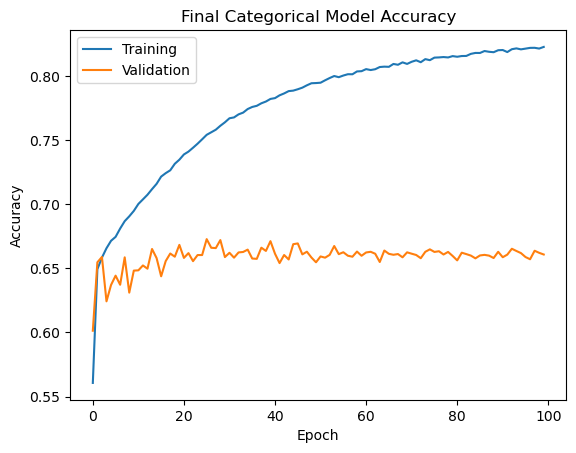

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot the accuracy over each epoch of training the final model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final Categorical Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.savefig("summary_stats/final_categorical_training_accuracy.svg")

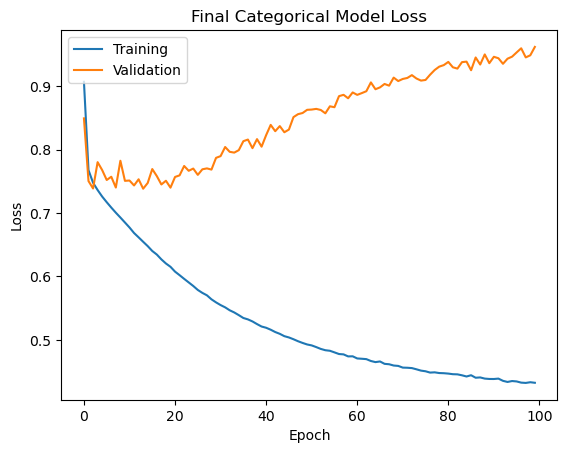

<Figure size 640x480 with 0 Axes>

In [24]:
# Plot the loss over each epoch of training the final model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final Categorical Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
plt.savefig("summary_stats/final_categorical_training_loss.svg")

In [26]:
# Add final statistics to a dataframe, print the dataframe, and output to a csv
stats_df = pd.DataFrame(iterations)
stats_df[['Accuracy', 'Loss']] = stats_df[['Accuracy', 'Loss']].round(3)
stats_df.to_csv("summary_stats/categorical_popularity_stats.csv", index=False)
stats_df

,Iteration,Loss,Accuracy
0,1,0.828,0.669
1,2,0.697,0.700
2,3,0.678,0.710
3,4,0.773,0.668
4,5,0.763,0.667
5,6,0.962,0.661
